# Basis Pursuit

This notebook serves to benchmark proximal projection (PP) against existing alternatives on an instance the basis pursuit problem

\begin{equation}
\min_{x\in\mathbb{R}^n} \|x\|_1 \ \ \text{s.t.}\ \ Ax = b.
\end{equation}

The first cell imports the needed libraries and defines the experiment setup: $m = 1250$ and $n=5000$ along with a function for logging perfomance of each algorithm.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

m     = 1250
n     = 5000
iters = 2000
seeds = 20

def shrink(xi, alpha):
    ''' Execute element-wise soft-threshold
    '''
    return  np.sign(xi) * np.maximum(np.abs(xi) - alpha, 0)


def update_stats(x, x_p, viol, obj, res, k):
    ''' Update arrays that store performance statistics.
    '''
    viol[k] = np.linalg.norm(A @ x - b)
    obj[k]  = np.linalg.norm(x, ord=1)
    res[k]  = np.linalg.norm(x - x_p)
    return viol, obj, res


## Define Algorithms

As defined in Appendix B.1 of the paper, here we implement the following:

* Proximal Projection (PP)
* Linearized Bregman (LB)
* Linearized Method of Multipliers (LMM)
* Primal Dual Hybrid Gradient (PDHG)

In [8]:
def PP(A, b, alpha=1.0e-1, num_iters=2000):
    ''' Execute proximal projection algorithm
    '''
    viol  = np.zeros(num_iters)
    obj   = np.zeros(num_iters)
    res   = np.zeros(num_iters)
    z     = np.zeros((n, 1))
    x     = np.zeros((n, 1))
    start = time.time()
    AAt   = np.linalg.inv(A @ A.T)    
    for k in range(num_iters):
        x_p = x.copy()
        x   = z - A.T @ (AAt @ (A @ z - b))
        z   = z + shrink(2.0 * x - z, alpha) - x 
        viol, obj, res = update_stats(x, x_p, viol, obj, res, k)
    stop = time.time()
    return x, viol, obj, res, (stop - start)


def LB(A, b, mu=2.0, num_iters=2000):
    ''' Execute linearized bregman algorithm

        Note: This solves the problem
               min  mu * ||x||_1 + ||x||_2^2 / 2 * alpha,
                x

              subject to the linear constraint A @ x = b.
              So, mu must be chosen "large enough" to ensure
              the minimizer of the L1 norm is obtained.
    '''
    viol   = np.zeros(num_iters)
    obj    = np.zeros(num_iters)
    res    = np.zeros(num_iters)
    x      = np.zeros((n, 1))
    v      = np.zeros((n, 1))
    start  = time.time()
    A_norm = np.linalg.norm(A @ A.T)
    alpha  = 2.0 / A_norm 
    mu    *= A_norm
    for k in range(num_iters):
        x_p = x.copy()
        v   = v - A.T @ (A @ x - b)
        x   = shrink(alpha * v, alpha * mu)
        viol, obj, res = update_stats(x, x_p, viol, obj, res, k)
    stop = time.time()
    return x, viol, obj, res, (stop - start)


def LMM(A, b, lambd=100.0, num_iters=2000):
    ''' Execute linearized method of multipliers algorithm
    '''
    viol   = np.zeros(num_iters)
    obj    = np.zeros(num_iters)
    res    = np.zeros(num_iters)
    x      = np.zeros((n, 1))
    v      = np.zeros((m, 1))     
    start  = time.time()    
    lambd *= np.linalg.norm(A.T @ A)
    alpha  = 1.0 / (lambd * np.linalg.norm(A.T @ A))
    for k in range(num_iters): 
        x_p = x.copy()
        x   = shrink(x - alpha * A.T @ (v + lambd * (A @ x - b)), alpha)
        v   = v + lambd * (A @ x - b)
        viol, obj, res = update_stats(x, x_p, viol, obj, res, k)
    stop = time.time()
    return x, viol, obj, res, (stop - start)


def PDHG(A, b, lambd=100.0, num_iters=2000):
    ''' Execute primal dual hybrid gradient algorithm
    '''
    viol  = np.zeros(num_iters)
    obj   = np.zeros(num_iters)
    res   = np.zeros(num_iters)
    x     = np.zeros((n, 1))
    v     = np.zeros((m, 1))
    alpha = 1.0 / (lambd * np.linalg.norm(A.T @ A))
    start = time.time()
    for k in range(num_iters):
        x_p = x.copy()
        x   = shrink(x - alpha * A.T @ v, alpha)
        v   = v + lambd * (A @ (2 * x - x_p) - b)
        viol, obj, res = update_stats(x, x_p, viol, obj, res, k)
    stop = time.time()
    return x, viol, obj, res, (stop - start)


# Benchmark Algorithms

We repeat 20 trials with different random seeds and report the median execution time of each algorithm.

In [9]:
viol  = np.zeros((4, seeds, iters))
obj   = np.zeros((4, seeds, iters))
res   = np.zeros((4, seeds, iters))
times = np.zeros((4, seeds))

for seed in range(seeds):
    print('seed = ', str(seed + 1), ' of ', seeds)
    np.random.seed(seed)
    A     = np.random.normal(0, 1.0/m, size=(m,n))
    x     = np.random.normal(0, 1.0, size=(n,1)) * np.random.binomial(n=1, p=0.05, size=(n,1))
    b     = A @ x

    _, viol[0, seed, :], obj[0, seed, :], res[0, seed, :], times[0, seed] = PP(A, b, num_iters=iters)
    _, viol[1, seed, :], obj[1, seed, :], res[1, seed, :], times[1, seed] = LMM(A, b, num_iters=iters)
    _, viol[2, seed, :], obj[2, seed, :], res[2, seed, :], times[2, seed] = LB(A, b, num_iters=iters)
    _, viol[3, seed, :], obj[3, seed, :], res[3, seed, :], times[3, seed] = PDHG(A, b, num_iters=iters)

viol_pp   = np.median(viol[0, :, :], axis=0)
viol_lmm  = np.median(viol[1, :, :], axis=0)
viol_lb   = np.median(viol[2, :, :], axis=0)
viol_pdhg = np.median(viol[3, :, :], axis=0)

obj_pp   = np.median(obj[0, :, :], axis=0)
obj_lmm  = np.median(obj[1, :, :], axis=0)
obj_lb   = np.median(obj[2, :, :], axis=0)
obj_pdhg = np.median(obj[3, :, :], axis=0)

res_pp   = np.median(res[0, :, :], axis=0)
res_lmm  = np.median(res[1, :, :], axis=0)
res_lb   = np.median(res[2, :, :], axis=0)
res_pdhg = np.median(res[3, :, :], axis=0)

times_pp   = np.mean(times[0, :])
times_lmm  = np.mean(times[1, :])
times_lb   = np.mean(times[2, :])
times_pdhg = np.mean(times[3, :])

print('PP   median time = %0.2f s' % times_pp)
print('LMM  median time = %0.2f s' % times_lmm)
print('LB   median time = %0.2f s' % times_lb)
print('PDHG median time = %0.2f s' % times_pdhg)

seed =  1  of  20
seed =  2  of  20
seed =  3  of  20
seed =  4  of  20
seed =  5  of  20
seed =  6  of  20
seed =  7  of  20
seed =  8  of  20
seed =  9  of  20
seed =  10  of  20
seed =  11  of  20
seed =  12  of  20
seed =  13  of  20
seed =  14  of  20
seed =  15  of  20
seed =  16  of  20
seed =  17  of  20
seed =  18  of  20
seed =  19  of  20
seed =  20  of  20
PP   median time = 8.06 s
LMM  median time = 22.85 s
LB   median time = 7.40 s
PDHG median time = 20.60 s


## Plot Median Convergence Results

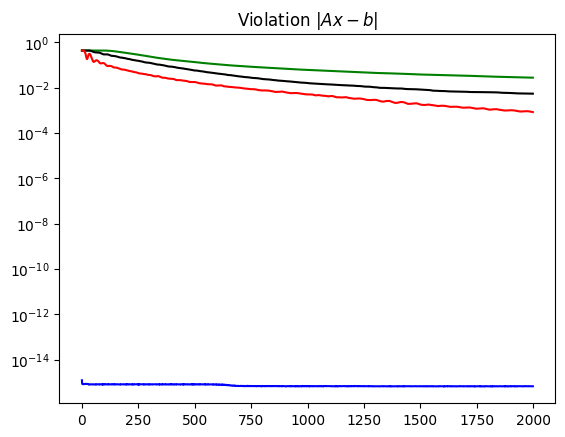

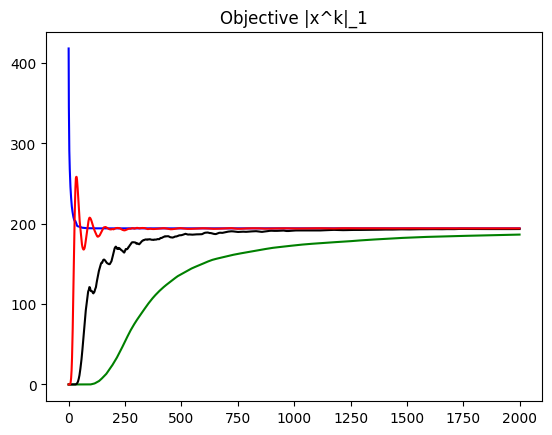

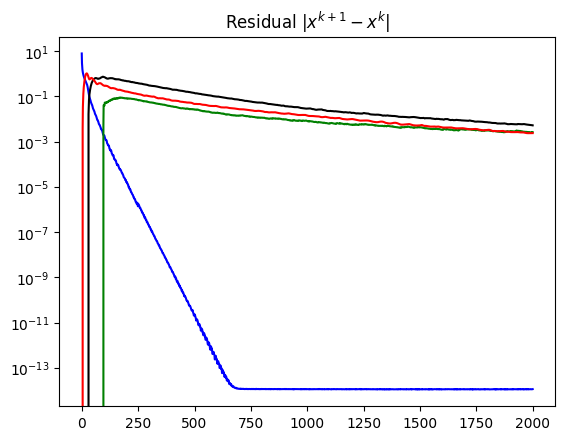

In [10]:
fig, ax = plt.subplots()
plt.title('Violation $|Ax-b|$')
plt.plot(viol_pp,   color='b')
plt.plot(viol_lb,   color='g')
plt.plot(viol_lmm,  color='k')
plt.plot(viol_pdhg, color='r')
plt.yscale('log')
plt.show()

fig, ax = plt.subplots()
plt.title('Objective |x^k|_1')
plt.plot(obj_pp,   color='b')
plt.plot(obj_lb,   color='g')
plt.plot(obj_lmm,  color='k')
plt.plot(obj_pdhg, color='r')
plt.show()
    
fig, ax = plt.subplots()
plt.title('Residual $|x^{k+1}-x^k|$')
plt.plot(res_pp,   color='b')
plt.plot(res_lb,   color='g')
plt.plot(res_lmm,  color='k')
plt.plot(res_pdhg, color='r')
plt.yscale('log')
plt.show()

## Save Plots and Times

In [11]:
filename = '../results/bp-obj-plots.csv'
with open(filename, 'w') as csv_file:
    for k in range(iters):
        if k % 1 == 0:
            csv_file.write('%0.5e,%0.5e,%0.5e,%0.5e\n' % (obj_pp[k],
                                                          obj_lmm[k],
                                                          obj_lb[k],
                                                          obj_pdhg[k]))
filename = '../results/bp-viol-plots.csv'
with open(filename, 'w') as csv_file:
    for k in range(iters):
        if k % 1 == 0:
            csv_file.write('%0.5e,%0.5e,%0.5e,%0.5e\n' % (viol_pp[k],
                                                          viol_lmm[k],
                                                          viol_lb[k],
                                                          viol_pdhg[k]))
filename = '../results/bp-res-plots.csv'
with open(filename, 'w') as csv_file:
    for k in range(iters):
        if k % 1 == 0:
            csv_file.write('%0.5e,%0.5e,%0.5e,%0.5e\n' % (res_pp[k],
                                                          res_lmm[k],
                                                          res_lb[k],
                                                          res_pdhg[k]))
filename = '../results/bp-times.tex'
with open(filename, 'w') as csv_file:
    csv_file.write('\\def\\bpTimePP{%0.2f}\n'   % (times_pp))
    csv_file.write('\\def\\bpTimeLB{%0.2f}\n'   % (times_lb))
    csv_file.write('\\def\\bpTimePDHG{%0.2f}\n' % (times_pdhg))
    csv_file.write('\\def\\bpTimeLMM{%0.2f}'  % (times_lmm))

## CVX Comparison

As a sanity check, we include a CVX implementation to compute the solution to the basis pursuit problem using the final seed from the above setup.

In [12]:
import cvxpy as cp

x           = cp.Variable((n,1))
objective   = cp.Minimize(cp.sum(cp.abs(x)))
constraints = [A @ x == b]
prob        = cp.Problem(objective, constraints)
result      = prob.solve(verbose=True)

print('|x| = ', np.sum(np.abs(x.value)))
print('|Ax - b| = ', np.sum(np.abs(A @ x.value - b)))

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 23 05:36:56 PM: Your problem has 5000 variables, 1250 constraints, and 0 parameters.
(CVXPY) Jul 23 05:36:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 23 05:36:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 23 05:36:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 23 05:36:56 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 23 05:36:56 PM: Compiling problem (target solver=CLARAB